In [1]:
from src.partition import Partition
from src.generators import PartitionClass
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import (
    Dense, Conv2D, Flatten, 
    ConvLSTM2D, BatchNormalization,
    Conv3D, Input, MaxPooling2D, UpSampling2D, Lambda
)
from keras.utils import plot_model
from keras.callbacks.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

Using TensorFlow backend.


In [257]:
n = 30

In [258]:
training_partitions = set(max(p, p.conjugate) for p in PartitionClass(n).partitions)
training_matrices = [p.matrix for p in training_partitions]
training_targets = [p.matrix for p in training_partitions]

X = np.array(training_matrices).reshape(-1, n, n, 1)
y = np.array(training_targets).reshape(-1, n, n, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# VAE

In [259]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [260]:
X_train = X_train.reshape((-1, n*n))
y_train = y_train.reshape((-1, n*n))
X_test = X_test.reshape((-1, n*n))
y_test = y_test.reshape((-1, n*n))

In [411]:
image_size = n
original_dim = n * n

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 100
latent_dim = 3
epochs = 1000

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 900)          0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 512)          461312      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            1539        dense_49[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 3)            1539        dense_49[0][0]                   
____________________________________________________________________________________________

In [412]:
models = (encoder, decoder)
data = (X_test, y_test)

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics = ['accuracy'])
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
es = EarlyStopping(monitor='val_loss', min_delta=.001, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
cbs = [es, lr]

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 900)               0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 464390    
_________________________________________________________________
decoder (Model)              (None, 900)               463748    
Total params: 928,138
Trainable params: 928,138
Non-trainable params: 0
_________________________________________________________________


/Users/brian/.virtualenvs/analytics/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning:

Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.



In [413]:
vae.fit(X_train,
        epochs=epochs,
        batch_size=5,#batch_size,
        validation_data=(X_test, None),
        callbacks = cbs,
        workers = 4)

Train on 2108 samples, validate on 703 samples
Epoch 1/1000
2108/2108 [==============================] - 4s 2ms/step - loss: 51.8481 - val_loss: 21.3264
Epoch 2/1000
2108/2108 [==============================] - 3s 2ms/step - loss: 18.2780 - val_loss: 16.8358
Epoch 3/1000
2108/2108 [==============================] - 3s 2ms/step - loss: 15.5801 - val_loss: 15.1468
Epoch 4/1000
2108/2108 [==============================] - 3s 2ms/step - loss: 14.7093 - val_loss: 14.1405
Epoch 5/1000
2108/2108 [==============================] - 3s 1ms/step - loss: 13.4906 - val_loss: 12.7123
Epoch 6/1000
2108/2108 [==============================] - 3s 1ms/step - loss: 12.4683 - val_loss: 12.1975
Epoch 7/1000
2108/2108 [==============================] - 3s 1ms/step - loss: 12.0660 - val_loss: 12.3257
Epoch 8/1000
2108/2108 [==============================] - 3s 1ms/step - loss: 12.0330 - val_loss: 12.2737
Epoch 9/1000
2108/2108 [==============================] - 3s 1ms/step - loss: 11.8345 - val_loss: 12.0830

KeyboardInterrupt: 

In [348]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    X_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(X_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=colorings, cmap = 'winter')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename, transparent = True)
    plt.show()

    filename = os.path.join(model_name, "partitions_over_latent.png")
    # display a 30x30 2D manifold of digits
    grid = 10
    digit_size = n
    figure = np.zeros((digit_size * grid, digit_size * grid))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, grid)
    grid_y = np.linspace(-4, 4, grid)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    
    scale = 2
    plt.figure(figsize=(grid * scale, grid * scale))
    start_range = digit_size // 2
    end_range = (grid - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename, transparent = True)
    plt.show()

In [433]:
partitions = []
for ptn_matrix in np.concatenate([y_train, y_test]).reshape(-1, n, n):
    parts = []
    for row in ptn_matrix:
        row_sum = sum(row)
        if not row_sum:
            break
        parts.append(int(row_sum))
        
    partitions.append(Partition(parts))
    

colorings = [int(p.is_stable) for p in partitions]

In [438]:
z_mean, _, _ = encoder.predict(np.concatenate([X_train, X_test]),
                                   batch_size=batch_size)

fig = go.Figure((go.Scatter3d(
    x=z_mean[:, 0],
    y = z_mean[:, 1],
    z = z_mean[:, 2],
    name="z",
    mode='markers',
    text = [repr(p) for p in partitions],
    marker=dict(
        size=10,
        color = colorings,
        colorscale='Viridis',
    )
)))

fig.update_layout(
    autosize=False,
    width=1300,
    height=1300,
)

fig.show()

In [398]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(
    x=z_mean[:, 0],
    y = z_mean[:, 1],
    mode='markers',
    text = [(repr(p), repr(p._next_oblak_step[1])) for p in partitions]

))

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)
fig.show()

In [349]:
[x for x in dir(Partition()) if not x.startswith('_')]

['ar_parts',
 'box_size',
 'conjugate',
 'crank',
 'durfee',
 'end',
 'fit_matrix',
 'index',
 'is_almost_rectangular',
 'is_stable',
 'iter_index',
 'matrix',
 'oblak',
 'parts',
 'rank',
 'reverse_insort',
 'rp',
 'sum_of_parts']

In [395]:
partitions = []
for ptn_matrix in np.concatenate([y_train, y_test]).reshape(-1, n, n):
    parts = []
    for row in ptn_matrix:
        row_sum = sum(row)
        if not row_sum:
            break
        parts.append(int(row_sum))
        
    partitions.append(Partition(parts))
    

colorings = [p[-1] for p in partitions]

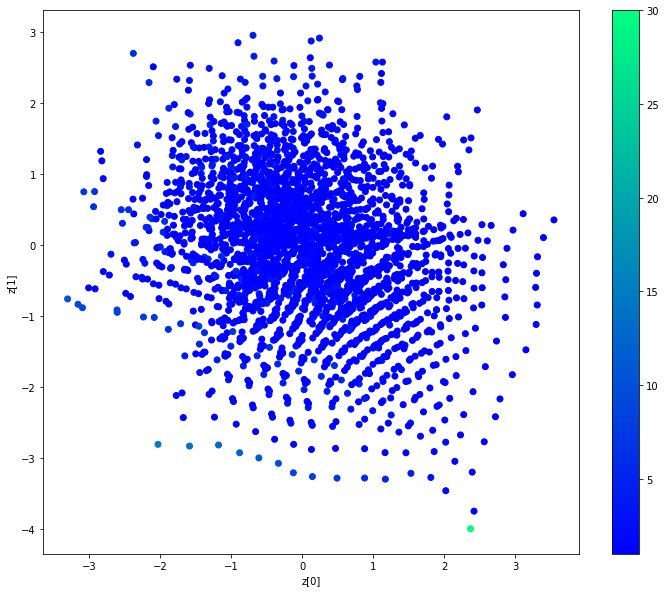

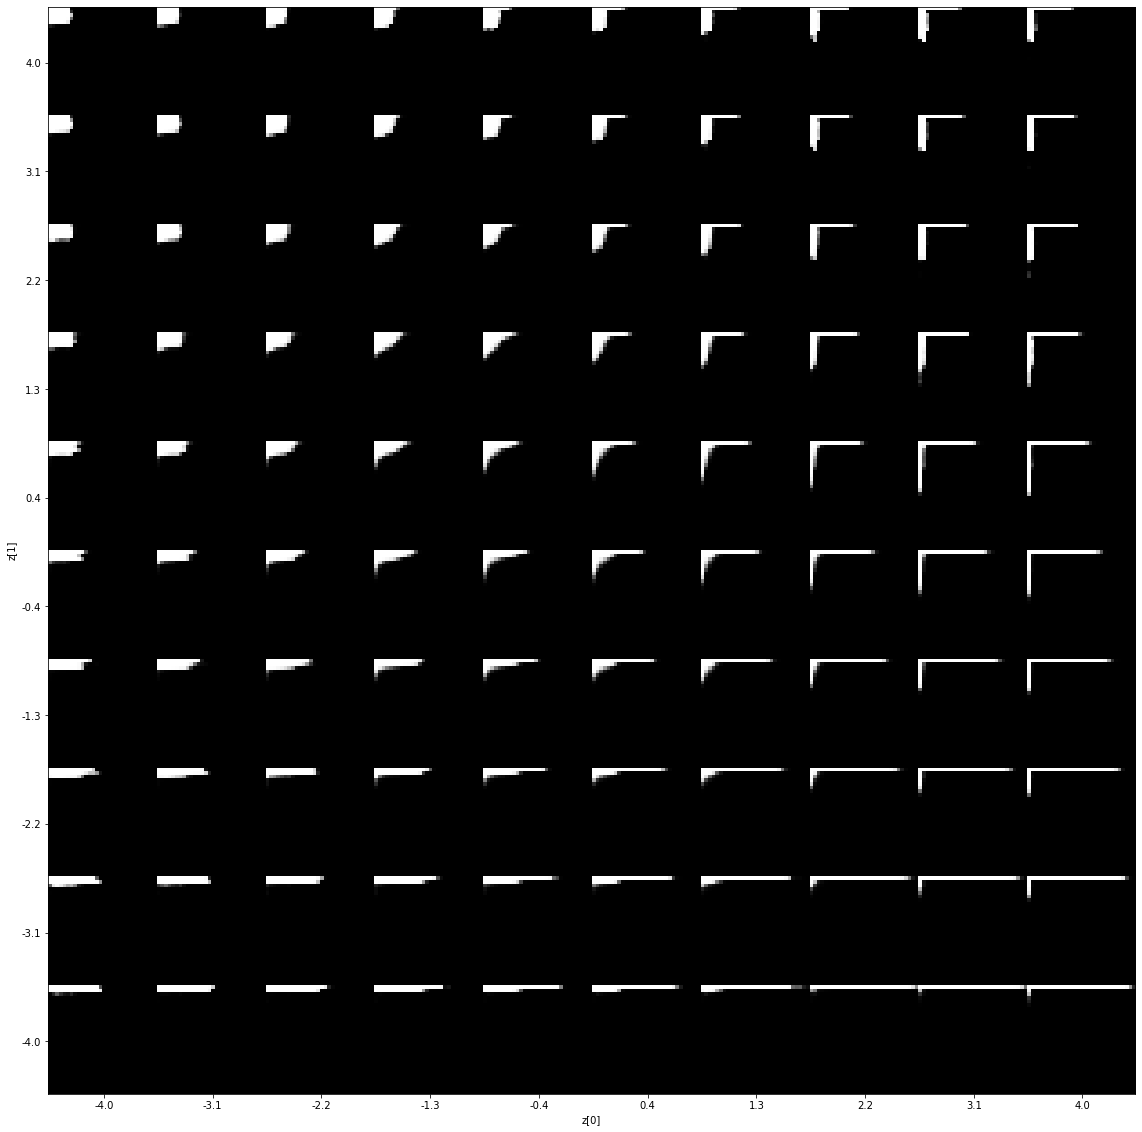

In [396]:
plot_results(models, (np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test])),
             batch_size=batch_size, model_name="vae_mlp")